In [1]:
import requests
import xml.etree.ElementTree as ET

def list_dataflows_insee():
    """
    Récupère la liste des regroupements thématiques (dataflows)
    exposés par l'API Insee via l'URL https://bdm.insee.fr/series/sdmx/dataflow
    Renvoie une liste de dictionnaires : [{'id':..., 'name_fr':..., 'url':...}, ...]
    """
    # 1) Faire la requête
    url = "https://bdm.insee.fr/series/sdmx/dataflow"
    response = requests.get(url)
    response.raise_for_status()

    # 2) Définir les namespaces repérés dans ta réponse XML
    ns = {
        'mes': "http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message",
        'str': "http://www.sdmx.org/resources/sdmxml/schemas/v2_1/structure",
        'com': "http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common"
    }

    # 3) Parser la réponse
    root = ET.fromstring(response.content)

    # On va stocker les dataflows dans une liste de dict
    dataflows = []

    # 4) Trouver tous les <str:Dataflow>
    for df in root.findall(".//str:Dataflow", ns):
        # Récupération de l'ID du dataflow
        dataflow_id = df.get("id")

        # On va chercher un <com:Name xml:lang="fr"> pour le nom français
        name_fr = None
        for name_node in df.findall("com:Name", ns):
            if name_node.attrib.get("{http://www.w3.org/XML/1998/namespace}lang") == 'fr':
                name_fr = name_node.text
                break

        # On peut également choper le 1er <com:AnnotationURL> si présent
        annotation_url_nodes = df.findall(".//com:AnnotationURL", ns)
        annotation_url = annotation_url_nodes[0].text if annotation_url_nodes else None

        dataflows.append({
            'id': dataflow_id,
            'name_fr': name_fr,
            'url': annotation_url
        })

    return dataflows

if __name__ == "__main__":
    dfs = list_dataflows_insee()

    for df in dfs:
        print(df)

{'id': 'BALANCE-PAIEMENTS', 'name_fr': 'Balance des paiements', 'url': 'https://www.insee.fr/fr/statistiques/series/103212755'}
{'id': 'CHOMAGE-TRIM-NATIONAL', 'name_fr': 'Chômage, taux de chômage par sexe et âge (sens BIT)', 'url': 'https://www.insee.fr/fr/statistiques/series/103167923'}
{'id': 'CLIMAT-AFFAIRES', 'name_fr': 'Indicateurs synthétiques du climat des affaires', 'url': 'https://www.insee.fr/fr/statistiques/series/103047029'}
{'id': 'CNA-2010-CONSO-MEN', 'name_fr': 'Consommation des ménages - Résultats par produit, fonction et durabilité', 'url': 'https://www.insee.fr/fr/statistiques/series/102331845'}
{'id': 'CNA-2010-CONSO-SI', 'name_fr': 'Dépenses de consommation finale par secteur institutionnel - Résultats par opération et produit', 'url': 'https://www.insee.fr/fr/statistiques/series/102809534'}
{'id': 'CNA-2010-CPEB', 'name_fr': 'Comptes de production et d’exploitation par branche', 'url': 'https://www.insee.fr/fr/statistiques/series/102852781'}
{'id': 'CNA-2010-CSI',

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_insee_structurespecific(xml_content, remove_stopped=True):
    """
    Parse the StructureSpecific SDMX XML response from Insee
    and return a pandas DataFrame with time series observations,
    taking into account that <Series> and <Obs> are in no namespace.
    """

    root = ET.fromstring(xml_content)
    all_rows = []

    # 1) Find all <Series> elements (no namespace)
    #    e.g.  <Series IDBANK="xxx"> <Obs TIME_PERIOD="yyy" /> ...
    series_list = root.findall(".//Series")  # no namespace prefix

    for series in series_list:
        # Each <Series> can have attributes like TITLE_FR, TITLE_EN, etc.
        s_attrib = series.attrib  # dictionary of attributes on <Series>
        if s_attrib.get("SERIE_ARRETEE") == "TRUE" and remove_stopped:
            continue

        # 2) Now find all <Obs> children (also in no namespace)
        #    We'll do series.findall("./Obs") to get direct children
        obs_list = series.findall("./Obs")

        for obs in obs_list:
            # The main attributes are TIME_PERIOD, OBS_VALUE, OBS_STATUS, etc.
            time_period = obs.get("TIME_PERIOD")
            obs_value_str = obs.get("OBS_VALUE")
            obs_status = obs.get("OBS_STATUS")

            # Convert obs_value to float (unless it's 'NaN')
            if obs_value_str == "NaN":
                obs_value = None
            else:
                try:
                    obs_value = float(obs_value_str)
                except (ValueError, TypeError):
                    obs_value = None\
            # Build a dict (row) for each observation
            row = {
                "TITLE_FR": s_attrib.get("TITLE_FR"),
                "TITLE_EN": s_attrib.get("TITLE_EN"),
                "STOPPED": s_attrib.get("SERIE_ARRETEE"),
                "LAST_UPDATE": s_attrib.get("LAST_UPDATE"),
                "FREQ": s_attrib.get("FREQ"),
                "LAST_UPDATED": s_attrib.get("LAST_UPDATED"),
                "IDBANK": s_attrib.get("IDBANK"),
                "INDICATEUR": s_attrib.get("INDICATEUR"),
                "CORRECTION": s_attrib.get("CORRECTION"),
                "NATURE": s_attrib.get("NATURE"),
                "UNIT": s_attrib.get("UNIT_MEASURE"),
                "MULT": s_attrib.get("UNIT_MULT"),
                "TIME_PERIOD": time_period,
                "OBS_VALUE": obs_value,
                "OBS_STATUS": obs_status,

            }
            all_rows.append(row)

    return pd.DataFrame(all_rows)


In [3]:
def fetch_insee_sdmx(url, params=None):
    if params is None:
        params = {}
    r = requests.get(url, params=params)

    if r.status_code == 200:
        return r.content
    else:
        content = r.content
        root = ET.fromstring(content)

        error_msg = root.find(".//{http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message}ErrorMessage")
        if error_msg is not None and error_msg.get("code") == "510":
            return content
        else:
            r.raise_for_status()

In [4]:
def parse_splitted_queries(xml_content):
    root = ET.fromstring(xml_content)

    error_msg = root.find(".//{http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message}ErrorMessage")
    splitted_queries = []

    if error_msg is not None and error_msg.get("code") == "510":
        ns_com = "{http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common}"
        text_elements = error_msg.findall(f".//{ns_com}Text")

        for el in text_elements:
            text_val = el.text or ""
            text_val = text_val.strip()
            if text_val.startswith("/data/"):
                splitted_queries.append(text_val)
    return splitted_queries

In [5]:
def fetch_insee_with_fallback(base_url, params=None):
    content = fetch_insee_sdmx(base_url, params=params)

    splitted_queries = parse_splitted_queries(content)

    if splitted_queries:
        dfs = []
        for path in splitted_queries:
            # Reconstruire l'URL complète
            sub_url = "https://bdm.insee.fr/series/sdmx" + path
            sub_content = fetch_insee_sdmx(sub_url, params=params)
            df_sub = parse_insee_structurespecific(sub_content, False)
            dfs.append(df_sub)
        return pd.concat(dfs, ignore_index=True)

    else:
        return parse_insee_structurespecific(content, False)

In [6]:
url = "https://bdm.insee.fr/series/sdmx/data/CLIMAT-AFFAIRES/all"

df = fetch_insee_with_fallback(url)

print("Nombre de lignes:", len(df))

Nombre de lignes: 1428


In [7]:
df.head(500)

,TITLE_FR,TITLE_EN,STOPPED,LAST_UPDATE,FREQ,LAST_UPDATED,IDBANK,INDICATEUR,CORRECTION,NATURE,UNIT,MULT,TIME_PERIOD,OBS_VALUE,OBS_STATUS
0,Indicateur du climat des affaires - Tous secte...,Business climate summary indicator - All secto...,None,2024-12-19,M,None,001565530,CLIMAT_AFFAIRES,BRUT,INDICE,SO,0,2024-12,94.3,A
1,Indicateur du climat des affaires - Tous secte...,Business climate summary indicator - All secto...,None,2024-12-19,M,None,001565530,CLIMAT_AFFAIRES,BRUT,INDICE,SO,0,2024-11,96.0,A
2,Indicateur du climat des affaires - Tous secte...,Business climate summary indicator - All secto...,None,2024-12-19,M,None,001565530,CLIMAT_AFFAIRES,BRUT,INDICE,SO,0,2024-10,97.4,A
3,Indicateur du climat des affaires - Tous secte...,Business climate summary indicator - All secto...,None,2024-12-19,M,None,001565530,CLIMAT_AFFAIRES,BRUT,INDICE,SO,0,2024-09,97.9,A
4,Indicateur du climat des affaires - Tous secte...,Business climate summary indicator - All secto...,None,2024-12-19,M,None,001565530,CLIMAT_AFFAIRES,BRUT,INDICE,SO,0,2024-08,96.7,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Indicateur du climat des affaires - Tous secte...,Business climate summary indicator - All secto...,None,2024-12-19,M,None,001565530,CLIMAT_AFFAIRES,BRUT,INDICE,SO,0,1983-09,78.2,A
496,Indicateur du climat des affaires - Tous secte...,Business climate summary indicator - All secto...,None,2024-12-19,M,None,001565530,CLIMAT_AFFAIRES,BRUT,INDICE,SO,0,1983-08,80.2,A
497,Indicateur du climat des affaires - Tous secte...,Business climate summary indicator - All secto...,None,2024-12-19,M,None,001565530,CLIMAT_AFFAIRES,BRUT,INDICE,SO,0,1983-07,79.1,A
498,Indicateur du climat des affaires - Tous secte...,Business climate summary indicator - All secto...,None,2024-12-19,M,None,001565530,CLIMAT_AFFAIRES,BRUT,INDICE,SO,0,1983-06,80.4,A


In [8]:
import pandas as pd
import numpy as np
import re

# ------------------------------------------------------------------------------
# 1) Example of a custom function to parse the TIME_PERIOD.
#    We assume it could be:
#       - "YYYY"
#       - "YYYY-Qi"  (i from 1 to 4)
#       - "YYYY-MM"
# ------------------------------------------------------------------------------

def parse_time_period(x):
    x = str(x).strip()

    # Match YYYY only
    match_year = re.match(r'^(\d{4})$', x)
    # Match YYYY-Q1, YYYY-Q2, etc.
    match_quarter = re.match(r'^(\d{4})-Q([1-4])$', x)
    # Match YYYY-MM
    match_month = re.match(r'^(\d{4})-(\d{2})$', x)

    if match_year:
        year = int(match_year.group(1))
        # Return something like 1st Jan of that year.
        # Alternatively, you can store it as a Period with annual frequency
        # return pd.Period(str(year), freq='A')
        return pd.to_datetime(f'{year}-01-01')

    elif match_quarter:
        year = int(match_quarter.group(1))
        quarter = int(match_quarter.group(2))
        # As a date, let's assume first day of that quarter:
        month_start = 3 * (quarter - 1) + 1  # Q1=1 -> Month=1, Q2=2 -> Month=4, etc.
        return pd.to_datetime(f'{year}-{month_start:02d}-01')
        # Alternatively, you can store it as a Period:
        # return pd.Period(f'{year}Q{quarter}', freq='Q')

    elif match_month:
        year = int(match_month.group(1))
        month = int(match_month.group(2))
        # 1st day of that month
        return pd.to_datetime(f'{year}-{month:02d}-01')

    else:
        # If it doesn't match any known pattern, return NaT or None
        return pd.NaT

# ------------------------------------------------------------------------------
# 2) Let's assume df is your initial dataframe with columns:
#    ['TITLE_FR', 'IDBANK', 'CORRECTION', 'NATURE', 'UNIT', 'MULT', 'TIME_PERIOD', 'OBS_VALUE', etc...]
# ------------------------------------------------------------------------------

def transform_insee_df(df):

    # Make a copy to avoid modifying the original
    df_copy = df.copy()

    # 2a) Parse the TIME_PERIOD into a new column with a standard format
    df_copy['DATE_PARSED'] = df_copy['TIME_PERIOD'].apply(parse_time_period)

    # 2b) Convert MULT to numeric (in case it is string) and handle missing
    #     If MULT is missing or empty, let's assume 0 -> 10**0 = 1
    df_copy['MULT'] = pd.to_numeric(df_copy['MULT'], errors='coerce').fillna(0)

    # 2c) Multiply OBS_VALUE by 10**MULT
    df_copy['OBS_VALUE'] = df_copy['OBS_VALUE'] * (10 ** df_copy['MULT'])

    # ----------------------------------------------------------------------------
    # 3) Create the pivoted table:
    #    index = DATE_PARSED
    #    columns = TITLE_FR
    #    values = OBS_VALUE
    # ----------------------------------------------------------------------------

    df_pivot = df_copy.pivot_table(
        index='DATE_PARSED',
        columns='TITLE_FR',
        values='OBS_VALUE',
        aggfunc='first'  # or 'mean', or another if you expect duplicates
    )

    # ----------------------------------------------------------------------------
    # 4) Build the metadata table:
    #    We want each TITLE_FR to have a single row with [IDBANK, CORRECTION, NATURE, UNIT, ...]
    #    That means we can group or drop duplicates.
    # ----------------------------------------------------------------------------

    metadata_cols = ['TITLE_FR', 'IDBANK', 'CORRECTION', 'NATURE', 'UNIT', 'STOPPED', 'LAST_UPDATE', 'FREQ']
    # Adjust the columns you want to keep for metadata
    df_metadata = df_copy[metadata_cols].drop_duplicates(subset='TITLE_FR').set_index('TITLE_FR')

    # Return both dataframes
    return df_pivot, df_metadata

In [39]:
df = fetch_insee_with_fallback("https://bdm.insee.fr/series/sdmx/data/CLIMAT-AFFAIRES/all")

In [40]:
df_pivot, df_metadata = transform_insee_df(df)
df_pivot.head()

TITLE_FR,Indicateur de retournement conjoncturel - Tous secteurs - France métropolitaine,Indicateur du climat de l'emploi - Tous secteurs - France metropolitaine,Indicateur du climat des affaires - Tous secteurs - France métropolitaine
DATE_PARSED,,,
1977-01-01,NaN,NaN,98.7
1977-02-01,NaN,NaN,101.3
1977-03-01,NaN,NaN,98.3
1977-04-01,NaN,NaN,94.4
1977-05-01,NaN,NaN,91.5


In [41]:
df_metadata.head()

,IDBANK,CORRECTION,NATURE,UNIT,STOPPED,LAST_UPDATE,FREQ
TITLE_FR,,,,,,,
Indicateur du climat des affaires - Tous secteurs - France métropolitaine,001565530,BRUT,INDICE,SO,None,2024-12-19,M
Indicateur du climat de l'emploi - Tous secteurs - France metropolitaine,001796629,BRUT,INDICE,SO,None,2024-12-19,M
Indicateur de retournement conjoncturel - Tous secteurs - France métropolitaine,001565531,BRUT,INDICE,SO,None,2024-12-19,M


In [42]:
# 1. Basic shape
print("Shape of pivoted dataframe:", df_pivot.shape)

# 2. Overall date range
print("Global start date:", df_pivot.index.min())
print("Global end date:", df_pivot.index.max())

# 3. Missing data info
missing_counts = df_pivot.isna().sum()
non_missing_counts = df_pivot.notna().sum()

print("\nMissing data counts per series:\n", missing_counts.head())
print("\nNon-missing data counts per series:\n", non_missing_counts.head())

# 4. First and last valid observation for each series
valid_obs_info = []
for col in df_pivot.columns:
    first_valid = df_pivot[col].first_valid_index()
    last_valid = df_pivot[col].last_valid_index()
    valid_obs_info.append((col, first_valid, last_valid))

df_valid_obs = pd.DataFrame(valid_obs_info, columns=['TITLE_FR', 'FirstValidDate', 'LastValidDate'])
print("\nFirst and Last valid observation for each series:\n", df_valid_obs.head(10))

Shape of pivoted dataframe: (576, 3)
Global start date: 1977-01-01 00:00:00
Global end date: 2024-12-01 00:00:00

Missing data counts per series:
 TITLE_FR
Indicateur de retournement conjoncturel - Tous secteurs - France métropolitaine    132
Indicateur du climat de l'emploi - Tous secteurs - France metropolitaine           168
Indicateur du climat des affaires - Tous secteurs - France métropolitaine            0
dtype: int64

Non-missing data counts per series:
 TITLE_FR
Indicateur de retournement conjoncturel - Tous secteurs - France métropolitaine    444
Indicateur du climat de l'emploi - Tous secteurs - France metropolitaine           408
Indicateur du climat des affaires - Tous secteurs - France métropolitaine          576
dtype: int64

First and Last valid observation for each series:
                                             TITLE_FR FirstValidDate  \
0  Indicateur de retournement conjoncturel - Tous...     1988-01-01   
1  Indicateur du climat de l'emploi - Tous secteu...   

In [49]:
df_valid_obs[df_valid_obs["FirstValidDate"] > "1987-01-01"]

,TITLE_FR,FirstValidDate,LastValidDate
0,Indicateur de retournement conjoncturel - Tous...,1988-01-01,2024-12-01
1,Indicateur du climat de l'emploi - Tous secteu...,1991-01-01,2024-12-01


In [13]:
# Summaries for numeric columns
df_pivot.describe().T

,count,mean,std,min,25%,50%,75%,max
TITLE_FR,,,,,,,,
Indicateur de retournement conjoncturel - Tous secteurs - France métropolitaine,444.0,0.234572,0.810579,-1.0,-0.700,0.80,1.00,1.0
Indicateur du climat de l'emploi - Tous secteurs - France metropolitaine,408.0,100.000000,9.999953,41.2,93.975,101.10,107.25,119.7
Indicateur du climat des affaires - Tous secteurs - France métropolitaine,576.0,100.002083,9.999379,47.1,93.600,101.55,106.75,120.9


In [14]:
freq_counts = df_metadata['FREQ'].value_counts(dropna=False)
print("\nFrequency counts:\n", freq_counts)


Frequency counts:
 FREQ
M    3
Name: count, dtype: int64


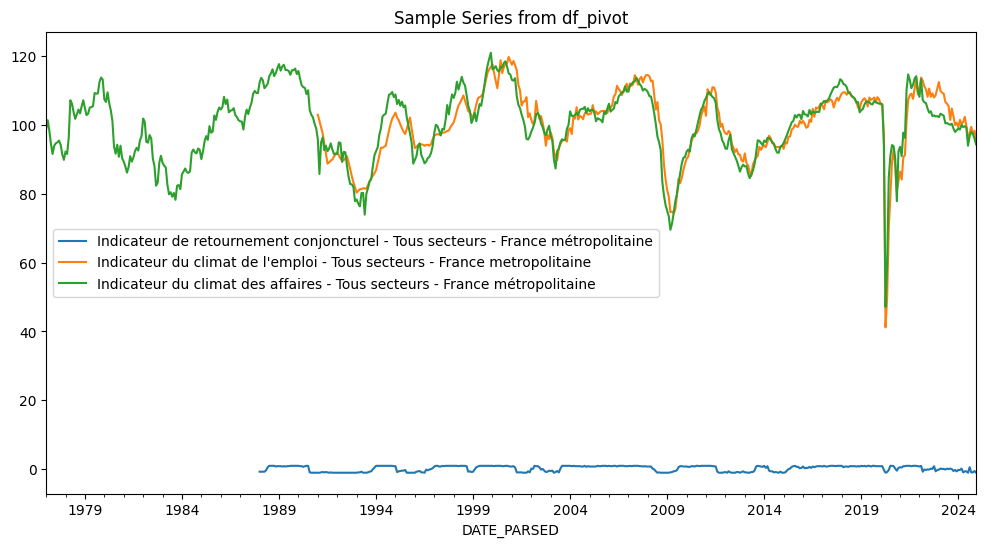

In [15]:
import matplotlib.pyplot as plt

some_titles = df_pivot.columns[:5]  # the first 5 series, for example
df_pivot[some_titles].plot(figsize=(12, 6))
plt.title("Sample Series from df_pivot")
plt.legend()
plt.show()

In [51]:
import pandas as pd

def drop_stopped_before(df_pivot, df_metadata, min_date):
    """
    Drops series (columns) from df_pivot and the corresponding rows in df_metadata
    whose last valid date is strictly earlier than the provided min_date.

    Parameters
    ----------
    df_pivot : pd.DataFrame
        Pivoted time series DataFrame with DateTime index and one column per time series.
        The column names should match df_metadata's index (usually TITLE_FR).
    df_metadata : pd.DataFrame
        Metadata table indexed by the same series identifiers (e.g. TITLE_FR).
    min_date : str or pd.Timestamp
        The cutoff date as a string or pd.Timestamp. Series with a last valid
        observation strictly before this date will be dropped.

    Returns
    -------
    df_pivot_filtered : pd.DataFrame
        The filtered pivot table with columns that pass the cutoff date check.
    df_metadata_filtered : pd.DataFrame
        The filtered metadata with matching rows retained.
    """

    # Ensure min_date is a Timestamp
    if not isinstance(min_date, pd.Timestamp):
        min_date = pd.to_datetime(min_date, errors='coerce')

    # Build a table of valid observation info for the pivot columns
    valid_obs_info = []
    for col in df_pivot.columns:
        last_valid = df_pivot[col].last_valid_index()
        valid_obs_info.append((col, last_valid))

    df_valid_obs = pd.DataFrame(valid_obs_info, columns=['TITLE_FR', 'last_valid'])

    # Filter columns whose last_valid is >= min_date
    keep_mask = df_valid_obs['last_valid'] >= min_date
    keep_columns = df_valid_obs.loc[keep_mask, 'TITLE_FR']

    # Now filter the pivot DataFrame
    df_pivot_filtered = df_pivot[keep_columns]

    # Filter the metadata by these same columns (TITLE_FR)
    df_metadata_filtered = df_metadata.loc[df_metadata.index.intersection(keep_columns)]

    return df_pivot_filtered, df_metadata_filtered

In [54]:
def drop_start_after(df_pivot, df_metadata, min_date):
    """
    Drops series (columns) from df_pivot and the corresponding rows in df_metadata
    whose first valid date is strictly later than the provided min_date.

    Parameters
    ----------
    df_pivot : pd.DataFrame
        Pivoted time series DataFrame with DateTime index and one column per time series.
        The column names should match df_metadata's index (usually TITLE_FR).
    df_metadata : pd.DataFrame
        Metadata table indexed by the same series identifiers (e.g. TITLE_FR).
    min_date : str or pd.Timestamp
        The cutoff date as a string or pd.Timestamp. Series with a first valid
        observation strictly after this date will be dropped.

    Returns
    -------
    df_pivot_filtered : pd.DataFrame
        The filtered pivot table with columns that pass the cutoff date check.
    df_metadata_filtered : pd.DataFrame
        The filtered metadata with matching rows retained.
    """

    # Ensure min_date is a Timestamp
    if not isinstance(min_date, pd.Timestamp):
        min_date = pd.to_datetime(min_date, errors='coerce')

    # Build a table of valid observation info for the pivot columns
    valid_obs_info = []
    for col in df_pivot.columns:
        first_valid = df_pivot[col].first_valid_index()
        valid_obs_info.append((col, first_valid))

    df_valid_obs = pd.DataFrame(valid_obs_info, columns=['TITLE_FR', 'first_valid'])

    # Filter columns whose first_valid is <= min_date
    keep_mask = df_valid_obs['first_valid'] <= min_date
    keep_columns = df_valid_obs.loc[keep_mask, 'TITLE_FR']

    # Now filter the pivot DataFrame
    df_pivot_filtered = df_pivot[keep_columns]

    # Filter the metadata by these same columns (TITLE_FR)
    df_metadata_filtered = df_metadata.loc[df_metadata.index.intersection(keep_columns)]

    return df_pivot_filtered, df_metadata_filtered

In [55]:
# Remove series that stopped before mid 2023
cutoff_date = "2023-06-01"
cutoff_first_date = "2016-01-01"
df_pivot_filtered, df_meta_filtered = drop_stopped_before(df_pivot, df_metadata, cutoff_date)
df_pivot_filtered, df_meta_filtered = drop_start_after(df_pivot_filtered, df_meta_filtered, cutoff_first_date)

print("Pivot shape before:", df_pivot.shape, "after:", df_pivot_filtered.shape)
print("Metadata shape before:", df_metadata.shape, "after:", df_meta_filtered.shape)

Pivot shape before: (576, 3) after: (576, 3)
Metadata shape before: (3, 7) after: (3, 7)


In [18]:
from inputs import SOURCE_TABLES
from tqdm import tqdm

l = []
for name in tqdm(SOURCE_TABLES):
    url = f"https://bdm.insee.fr/series/sdmx/data/{name}/all"
    df = fetch_insee_with_fallback(url)
    df_pivoted, df_meta = transform_insee_df(df)
    df_pivoted_filtered, df_meta_filtered = drop_stopped_before(df_pivoted, df_meta, "2023-01-01")
    df_pivot_filtered, df_meta_filtered = drop_start_after(df_pivoted_filtered, df_meta_filtered, "2016-01-01")
    l.append((df_pivoted_filtered, df_meta_filtered))

100%|██████████| 100/100 [1:09:13<00:00, 41.54s/it]


In [8]:
# Build the list of URLs keyed by name
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed
from inputs import SOURCE_TABLES
from tqdm.notebook import tqdm
urls = {name: f"https://bdm.insee.fr/series/sdmx/data/{name}/all" for name in SOURCE_TABLES}

fetched_results = {}

# 1) Fetch data in parallel
with ThreadPoolExecutor(max_workers=5) as executor:
    # Create a mapping of futures to the source name
    future_to_name = {
        executor.submit(fetch_insee_with_fallback, url): name
        for name, url in urls.items()
    }

    # Collect results as they come in
    for future in as_completed(future_to_name):
        name = future_to_name[future]
        try:
            df = future.result()  # This is the returned DataFrame
            fetched_results[name] = df
        except Exception as exc:
            print(f"Error fetching {name}: {exc}")
            fetched_results[name] = None

# 2) Transform data one by one (synchronously) and store on disk
all_transformed = []
for name in tqdm(SOURCE_TABLES, desc="Transforming data"):
    df = fetched_results[name]
    if df is not None:
        # Transform
        df_pivoted, df_meta = transform_insee_df(df)

        # Filter
        df_pivoted_filtered, df_meta_filtered = drop_stopped_before(
            df_pivoted, df_meta, "2023-01-01"
        )

        # Write out to CSV if desired
        df_pivoted_filtered.to_csv(f"{name}_pivoted_filtered.csv", index=False)
        df_meta_filtered.to_csv(f"{name}_meta_filtered.csv", index=False)

        # Keep them in a list for later usage
        all_transformed.append((df_pivoted_filtered, df_meta_filtered))
    else:
        # In case you want to keep a placeholder for failed fetches
        all_transformed.append((None, None))

print("All data fetched in parallel, transformed sequentially, and saved to disk!")

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [22]:
print(SOURCE_TABLES)

['BALANCE-PAIEMENTS', 'CHOMAGE-TRIM-NATIONAL', 'CLIMAT-AFFAIRES', 'CNA-2020-CONSO-MEN', 'CNA-2020-CONSO-SI', 'CNA-2020-CPEB', 'CNA-2020-CSI', 'CNA-2020-EMPLOI', 'CNA-2020-ERE', 'CNA-2020-FBCF-SI', 'CNA-2020-PIB', 'CNA-2020-TEI', 'CNT-2020-CB', 'CNT-2020-CSI', 'CNT-2020-OPERATIONS', 'CNT-2020-PIB-EQB-RF', 'COM-EXT', 'COMPTES-ETAT', 'CONSO-MENAGES-2020', 'CONSTRUCTION-LOCAUX', 'CONSTRUCTION-LOGEMENTS', 'CREATIONS-ENTREPRISES', 'CREATIONS-ENTREPRISES-METHODE-2022', 'DECES-MORTALITE', 'DEFAILLANCES-ENTREPRISES', 'DEMANDES-EMPLOIS-NATIONALES', 'DETTE-NEGOCIABLE-ETAT', 'DETTE-TRIM-APU-2020', 'EMPLOI-BIT-TRIM', 'EMPLOI-SALARIE-TRIM-NATIONAL', 'ENQ-CONJ-ACT-IND', 'ENQ-CONJ-ART-BAT', 'ENQ-CONJ-COM-DET', 'ENQ-CONJ-COM-GROS', 'ENQ-CONJ-IND-BAT', 'ENQ-CONJ-INV-IND', 'ENQ-CONJ-MENAGES', 'ENQ-CONJ-PROMO-IMMO', 'ENQ-CONJ-SERV', 'ENQ-CONJ-TP', 'ENQ-CONJ-TRES-IND', 'ERI-ACTIVITE-PARTIELLE', 'IC-PROD-CONS-2021', 'ICA-2021-COMMERCE', 'ICA-2021-IND-CONS', 'ICA-2021-SERVICES', 'ICT-2020', 'INDICE-TRAITEMEN

In [24]:
import json


with open("Data/all_data.json", 'r') as f:
    file_names = json.load(f)

print(set(SOURCE_TABLES) - set(file_names))

{'ENQ-CONJ-TRES-IND', 'CREATIONS-ENTREPRISES', 'SUIVI-DEMANDE-TOURISTIQUE', 'ENQ-CONJ-COM-GROS'}


In [34]:
print(len(SOURCE_TABLES))

100


In [36]:
for i, name in enumerate(SOURCE_TABLES):
    test_df = l[i][0]
    print(name, test_df.shape)

BALANCE-PAIEMENTS (197, 193)
CHOMAGE-TRIM-NATIONAL (199, 104)
CLIMAT-AFFAIRES (576, 3)
CNA-2020-CONSO-MEN (75, 1441)
CNA-2020-CONSO-SI (75, 597)
CNA-2020-CPEB (75, 504)
CNA-2020-CSI (75, 5)
CNA-2020-EMPLOI (75, 262)
CNA-2020-ERE (75, 1193)
CNA-2020-FBCF-SI (75, 15)
CNA-2020-PIB (75, 21)
CNA-2020-TEI (75, 87)
CNT-2020-CB (303, 594)
CNT-2020-CSI (303, 334)
CNT-2020-OPERATIONS (303, 682)
CNT-2020-PIB-EQB-RF (303, 68)
COM-EXT (311, 1543)
COMPTES-ETAT (190, 4)
CONSO-MENAGES-2020 (539, 16)
CONSTRUCTION-LOCAUX (371, 1236)
CONSTRUCTION-LOGEMENTS (371, 608)
CREATIONS-ENTREPRISES (277, 0)
CREATIONS-ENTREPRISES-METHODE-2022 (299, 1456)
DECES-MORTALITE (992, 1650)
DEFAILLANCES-ENTREPRISES (435, 572)
DEMANDES-EMPLOIS-NATIONALES (359, 1730)
DETTE-NEGOCIABLE-ETAT (191, 17)
DETTE-TRIM-APU-2020 (116, 21)
EMPLOI-BIT-TRIM (87, 123)
EMPLOI-SALARIE-TRIM-NATIONAL (216, 79)
ENQ-CONJ-ACT-IND (585, 1599)
ENQ-CONJ-ART-BAT (132, 84)
ENQ-CONJ-COM-DET (408, 422)
ENQ-CONJ-COM-GROS (0, 0)
ENQ-CONJ-IND-BAT (451, 205)

In [58]:
file_names = []

for i, name in enumerate(SOURCE_TABLES):
    df, meta = l[i]
    df_f, df_meta_f = drop_start_after(df, meta, "2016-01-01")
    if df_f.shape[1] == 0:
        print(f"Empty DataFrame for {name}")
        continue

    df_f.to_csv(f"Data/{name}.csv")
    df_meta_f.to_csv(f"Data/{name}_meta.csv")
    file_names.append(name)

with open("Data/all_data.json", 'w') as f:
    json.dump(file_names, f)

Empty DataFrame for CREATIONS-ENTREPRISES
Empty DataFrame for ENQ-CONJ-COM-GROS
Empty DataFrame for ENQ-CONJ-INV-IND
Empty DataFrame for ENQ-CONJ-TRES-IND
Empty DataFrame for ERI-ACTIVITE-PARTIELLE
Empty DataFrame for IPI-1990
Empty DataFrame for SALAIRES-ACEMO
Empty DataFrame for SALAIRES-ACEMO-2017
Empty DataFrame for SUIVI-DEMANDE-TOURISTIQUE
Empty DataFrame for TCRED-EDUCATION-APP-JEN
Empty DataFrame for TCRED-EDUCATION-DIPLOMES-TECHNIQUES
Empty DataFrame for TCRED-EDUCATION-REU-BAC
Empty DataFrame for TCRED-ENTREPRISES-EFF-OPE
Empty DataFrame for TCRED-ENTREPRISES-EMP-SAL-AN-TAILLE
Empty DataFrame for TCRED-SALAIRES-REVENUS-MEN
Empty DataFrame for TCRED-SALAIRES-REVENUS-RET-BEN
Empty DataFrame for TCRED-SALAIRES-REVENUS-REV-SAL-SEXE-CS
Empty DataFrame for TCRED-SALAIRES-REVENUS-TAUX-PAUVRETE-AGE
Empty DataFrame for TCRED-SALAIRES-REVENUS-TNB
Empty DataFrame for TCRED-SANTE-ACCUEIL-PERS-AGEES
Empty DataFrame for TCRED-TRAVAIL-EMPLOI-EFF-FP-RATIO
Empty DataFrame for TCRED-TRAVAIL-EM

In [ ]:
all_names = []
for name, dfs in zip(SOURCE_TABLES, l):
    name = name.replace(" ","")
    df, meta = dfs
    df.to_csv(f"Data/{name}.csv")
    meta.to_csv(f"Data/{name}_meta.csv")
    all_names.append(name)

import json

with open("Data/all_data.json", 'w') as f:
    json.dump(all_names, f)

In [ ]:
df_meta.head(100)

In [ ]:
import json
from inputs import SOURCE_TABLES
import pandas as pd

# 1) Load all the files
with open("Data/all_data.json", 'r') as f:
    file_names = json.load(f)

file_names = [f"Data/{x}.csv" for x in file_names]

# 2) Load them into individual DataFrames
df_list = []
for file in file_names:
    temp_df = pd.read_csv(
        file,
        parse_dates=["DATE_PARSED"]  # adjust if your date column differs
    )
    df_list.append(temp_df)

# 3) Merge all DataFrames on DATE_PARSED
merged_df = df_list[0]
for i in range(1, len(df_list)):
    merged_df = pd.merge(
        merged_df,
        df_list[i],
        on="DATE_PARSED",
        how="outer"
    )

# 4) Set DATE_PARSED as index
merged_df.set_index("DATE_PARSED", inplace=True)
merged_df.sort_index(inplace=True)

# 5) Calculate the percentage of missing columns for each date
merged_df["pct_missing"] = merged_df.isna().mean(axis=1) * 100

# 6) (Optional) If you'd like to see average missingness by year/quarter/month, you can do:
# e.g., monthly
monthly_missing = merged_df.resample('M')["pct_missing"].mean()

# or yearly
yearly_missing = merged_df.resample('Y')["pct_missing"].mean()

print("Monthly % of Missing Columns:")
print(monthly_missing)

print("\nYearly % of Missing Columns:")
print(yearly_missing)

In [ ]:
monthly_missing.iloc[750:].describe()